In [1]:
# useful to autoreload the module without restarting the kernel
%load_ext autoreload
%autoreload 2

In [39]:
from mppi import InputFiles as I, Calculators as C, Datasets as D, Utilities as U, Parsers as P
import matplotlib.pyplot as plt
import numpy as np
import os

In [40]:
omp = 1
mpi_run = 'mpirun -np 16'

# RT analysis of GaAs

This notebook contains the RT analysis of the GaAs performed with Yambo. In particular

* Construction of the RT SAVE folder using ypp
* Definition of the Dataset with the RT computations

We select the source_dir used to generate the base SAVE folder and the associated Yambo run_dir

In [41]:
#source_dir = 'NSCF/bnds_16-sampling_gamma.save'
source_dir = 'NSCF/bnds_16-sampling_1k-nosym.save'

#run_dir = 'RT_Gamma'
run_dir = 'RT_1k-nosym'

## Construction of the FixSymm folder

The first step of this procedure is represented by the construction of the Yambo run_dir with the SAVE directory. 



In [42]:
U.build_SAVE(source_dir,run_dir,make_link=True)

Create folder RT_1k-nosym
Executing command: cd NSCF/bnds_16-sampling_1k-nosym.save; p2y -a 2
Create a symlink of /data/dalessandro/work/TiSPiEGA-Project/NSCF/bnds_16-sampling_1k-nosym.save/SAVE in RT_1k-nosym
Executing command: cd RT_1k-nosym;OMP_NUM_THREADS=1 yambo


Perform the fixSymm procedure to build the SAVE folder for the RT analysis

In [43]:
fixSymm_inp = I.YamboInput('ypp -y',folder=run_dir)
fixSymm_inp.removeTimeReversal()
fixSymm_inp.set_ypp_extFields(Efield1=[1.,0.,0.],Efield2=[0.,1.,0.])
#fixSymm_inp

In [44]:
code = C.YamboCalculator(mpi_run='mpirun -np 1',executable='ypp',skip=False)

Initialize a parallel Yambo calculator with scheduler direct


In [45]:
code.run(inputs=[fixSymm_inp],names=['FixSymm'],run_dir=run_dir)

Executing command: cd RT_1k-nosym; mpirun -np 1 ypp -F FixSymm.in -J FixSymm -C FixSymm
run0_is_running:True  
Job completed


{'dbs': ['RT_1k-nosym/FixSymm'], 'output': [[]]}

Run yambo_rt in the FixSymm folder to build the r_setup

In [46]:
rt_run_dir = os.path.join(run_dir,'FixSymm')
command = 'cd %s; yambo_rt'%rt_run_dir
os.system(command)

0

## RT calculations

We build the input(s) and run the calculations for the RT analysis. 

First of all we identify the run_dir for RT analysis and (if needed) we change the name of the ns.kb_pp_pwscf database to non-local
contributions of the psp

In [47]:
rt_run_dir = os.path.join(run_dir,'FixSymm')
rt_run_dir

'RT_1k-nosym/FixSymm'

In [48]:
db = 'ns.kb_pp_pwscf'
src = os.path.join(rt_run_dir,'SAVE',db)
dst = os.path.join(rt_run_dir,'SAVE',db+'_hide')
command = 'mv %s %s'%(src,dst)
print(command)
os.system(command)

mv RT_1k-nosym/FixSymm/SAVE/ns.kb_pp_pwscf RT_1k-nosym/FixSymm/SAVE/ns.kb_pp_pwscf_hide


0

We define the basic elements of the input file

In [49]:
#field parameters
field_int = 1000.0 #kWLm2
field_width = 100 #fs
field_pol = 'circular'
field_freq = 1.55 #eV

# system parameters
bands = [3,10] #[2,9] #[3,10] # from the split-off bands (3,4) to the first conduction bands (9,10)
scissor = 0.5467 # (eV) (taken from QE_Analysis it gives a direct gap of 1.42 eV)
deph_val  = 0.002 # (eV) the sum of the dephasings is 1/10 of the field spread
deph_cond = deph_val# eV 

# simulation parameters
time_step = 10 #as
sim_time = 1000 # fs 6*field_width
k_parallel = int(mpi_run.lstrip('mpirun -np '))

In [50]:
rt_input = I.YamboInput('yambo_rt -n p -v ip -V qp',folder=rt_run_dir)
rt_input.set_rt_field(int=field_int,width=field_width,polarization=field_pol,freq=field_freq)
rt_input.set_rt_bands(bands=bands,scissor=scissor,damping_valence=deph_val,damping_conduction=deph_cond)
rt_input.set_rt_simulationTimes(sim_time=sim_time,time_units='fs',time_step=time_step)
rt_input.set_rt_cpu(k_parallel)
rt_input

{'args': 'yambo_rt -n p -v ip -V qp',
 'arguments': ['negf'],
 'filename': 'yambo.in',
 'folder': 'RT_1k-nosym/FixSymm',
 'variables': {'FFTGvecs': [3527.0, 'RL'],
  'Field1_Dir': [[1.0, 0.0, 0.0], ''],
  'Field1_Dir_circ': [[0.0, 1.0, 0.0], ''],
  'Field1_Freq': [[1.55, 1.55], 'eV'],
  'Field1_Int': [1000.0, 'kWLm2'],
  'Field1_Tstart': [0.0, 'fs'],
  'Field1_Width': [100, 'fs'],
  'Field1_kind': 'QSSIN',
  'Field1_pol': 'circular',
  'GfnQP_E': [[0.5467, 1.0, 1.0], ''],
  'GfnQP_N': [1.0, ''],
  'GfnQP_Wc': [[0.002, 0.0, 0.0], ''],
  'GfnQP_Wc_E': [0.0, 'eV'],
  'GfnQP_Wc_dos': [0.0, 'eV'],
  'GfnQP_Wv': [[0.002, 0.0, 0.0], ''],
  'GfnQP_Wv_E': [0.0, 'eV'],
  'GfnQP_Wv_dos': [0.0, 'eV'],
  'GfnQP_Z': [(1+0j), ''],
  'GfnQPdb': 'none',
  'HXC_Potential': 'IP',
  'IOtime': [[1.0, 5.0, 1.0], 'fs'],
  'Integrator': 'RK2',
  'NETime': [1000, 'fs'],
  'PhLifeTime': [0.0, 'fs'],
  'RTBands': [[3, 10], ''],
  'RT_CPU': '16.1.1.1',
  'RT_Threads': [0.0, ''],
  'RTstep': [10, 'as']}}

In [77]:
code = C.YamboCalculator(omp=omp,mpi_run=mpi_run,executable='yambo_rt',skip=True,verbose=True,IO_time=20)
code.global_options()

Initialize a parallel Yambo calculator with scheduler direct


{'IO_time': 20,
 'cpus_per_task': 4,
 'executable': 'yambo_rt',
 'mpi_run': 'mpirun -np 16',
 'multiTask': True,
 'ntasks': 3,
 'omp': 1,
 'scheduler': 'direct',
 'skip': True,
 'verbose': True}

Now we can perform various computations

## Single computation. Analysis of the time dependence of the spin magnetization

Eventually the basic parameters of the rt_input can be modified and then we perform a single computation.

The relevant parameters used as input are stored in the name of the input (and in the folder that contains the output
files and the database)

### RT computation at $\Gamma$

We tune the frequency of the pump at the value of the direct gap at $\Gamma$

In [34]:
field_freq = 1.42
rt_input.set_rt_field(int=field_int,width=field_width,polarization=field_pol,freq=field_freq)
#rt_input

In [15]:
idd = {'simTime':sim_time,'dephase':deph_val,'int':field_int,'freq':field_freq}
name = D.name_from_id(idd)
name

'dephase_0.002-freq_1.42-int_1000.0-simTime_1000'

In [16]:
result = code.run(inputs=[rt_input],names=[name],run_dir=rt_run_dir)
result

delete folder: RT_Gamma/FixSymm/dephase_0.002-freq_1.42-int_1000.0-simTime_1000
Executing command: cd RT_Gamma/FixSymm; mpirun -np 16 yambo_rt -F dephase_0.002-freq_1.42-int_1000.0-simTime_1000.in -J dephase_0.002-freq_1.42-int_1000.0-simTime_1000 -C dephase_0.002-freq_1.42-int_1000.0-simTime_1000
run0_is_running:True  
run0_is_running:True  
run0_is_running:True  
run0_is_running:True  
run0_is_running:True  
run0_is_running:True  
run0_is_running:True  
run0_is_running:True  
run0_is_running:True  
run0_is_running:True  
Job completed


{'dbs': ['RT_Gamma/FixSymm/dephase_0.002-freq_1.42-int_1000.0-simTime_1000'],
 'output': [['RT_Gamma/FixSymm/dephase_0.002-freq_1.42-int_1000.0-simTime_1000/o-dephase_0.002-freq_1.42-int_1000.0-simTime_1000.current',
   'RT_Gamma/FixSymm/dephase_0.002-freq_1.42-int_1000.0-simTime_1000/o-dephase_0.002-freq_1.42-int_1000.0-simTime_1000.polarization',
   'RT_Gamma/FixSymm/dephase_0.002-freq_1.42-int_1000.0-simTime_1000/o-dephase_0.002-freq_1.42-int_1000.0-simTime_1000.carriers',
   'RT_Gamma/FixSymm/dephase_0.002-freq_1.42-int_1000.0-simTime_1000/o-dephase_0.002-freq_1.42-int_1000.0-simTime_1000.external_field',
   'RT_Gamma/FixSymm/dephase_0.002-freq_1.42-int_1000.0-simTime_1000/o-dephase_0.002-freq_1.42-int_1000.0-simTime_1000.spin_magnetization',
   'RT_Gamma/FixSymm/dephase_0.002-freq_1.42-int_1000.0-simTime_1000/o-dephase_0.002-freq_1.42-int_1000.0-simTime_1000.orbt_magnetization']]}

In [35]:
data = P.YamboParser(result['output'][0])
data.keys()

dict_keys(['polarization', 'current', 'carriers', 'external_field', 'spin_magnetization', 'orbt_magnetization'])

In [19]:
field = data['external_field']
carriers = data['carriers']
spin = data['spin_magnetization']

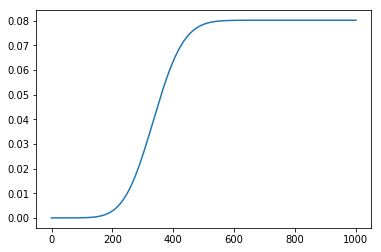

In [20]:
plt.plot(carriers['time'],carriers['dne'])

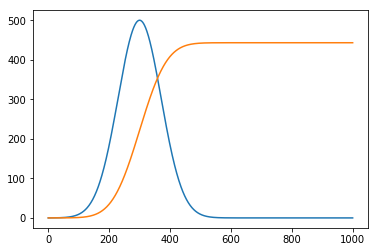

In [22]:
plt.plot(field['time'],field['Intensity'])
plt.plot(field['time'],5*field['Fluence'])

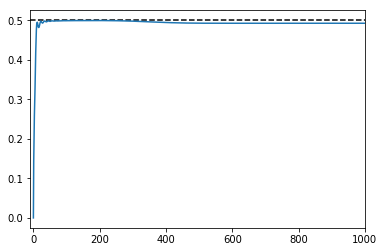

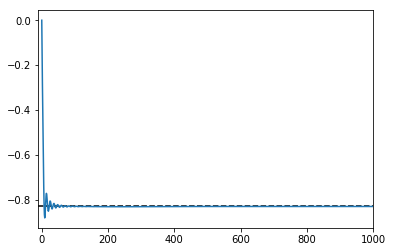

In [33]:
plt.plot(spin['time'],spin['Mc_z'])
plt.hlines(0.5,-10,1100,linestyles='--')
plt.xlim(-10,1000)
plt.show()

plt.plot(spin['time'],spin['Mv_z'])
plt.hlines(-0.83,-10,1100,linestyles='--')
plt.xlim(-10,1000)
plt.show()


In [37]:
spin['Mc_z'][100]

0.49889318

### RT computation for a single kpoint 

We analyze the case of a single kpoint close to $\Gamma$ but outside the high symmetry directions

We tune the frequency of the pump at the value average gap of this point. We also reduce the damping and increase
the simulation time to be able to study the time dynamics of the signal

In [81]:
field_freq = 2.15
deph_val  = 1.e-4 # (eV) 
deph_cond = deph_val 
sim_time = 4000 

rt_input.set_rt_field(int=field_int,width=field_width,polarization=field_pol,freq=field_freq)
rt_input.set_rt_bands(bands=bands,scissor=scissor,damping_valence=deph_val,damping_conduction=deph_cond)
rt_input.set_rt_simulationTimes(sim_time=sim_time,time_units='fs',time_step=time_step)
rt_input

{'args': 'yambo_rt -n p -v ip -V qp',
 'arguments': ['negf'],
 'filename': 'yambo.in',
 'folder': 'RT_1k-nosym/FixSymm',
 'variables': {'FFTGvecs': [3527.0, 'RL'],
  'Field1_Dir': [[1.0, 0.0, 0.0], ''],
  'Field1_Dir_circ': [[0.0, 1.0, 0.0], ''],
  'Field1_Freq': [[2.15, 2.15], 'eV'],
  'Field1_Int': [1000.0, 'kWLm2'],
  'Field1_Tstart': [0.0, 'fs'],
  'Field1_Width': [100, 'fs'],
  'Field1_kind': 'QSSIN',
  'Field1_pol': 'circular',
  'GfnQP_E': [[0.5467, 1.0, 1.0], ''],
  'GfnQP_N': [1.0, ''],
  'GfnQP_Wc': [[0.0001, 0.0, 0.0], ''],
  'GfnQP_Wc_E': [0.0, 'eV'],
  'GfnQP_Wc_dos': [0.0, 'eV'],
  'GfnQP_Wv': [[0.0001, 0.0, 0.0], ''],
  'GfnQP_Wv_E': [0.0, 'eV'],
  'GfnQP_Wv_dos': [0.0, 'eV'],
  'GfnQP_Z': [(1+0j), ''],
  'GfnQPdb': 'none',
  'HXC_Potential': 'IP',
  'IOtime': [[1.0, 5.0, 1.0], 'fs'],
  'Integrator': 'RK2',
  'NETime': [4000, 'fs'],
  'PhLifeTime': [0.0, 'fs'],
  'RTBands': [[3, 10], ''],
  'RT_CPU': '16.1.1.1',
  'RT_Threads': [0.0, ''],
  'RTstep': [10, 'as']}}

In [128]:
idd = {'simTime':sim_time,'dephase':deph_val,'int':field_int,'freq':field_freq}
name = D.name_from_id(idd)
name

'dephase_0.0001-freq_2.15-int_1000.0-simTime_4000'

In [130]:
result = code.run(inputs=[rt_input],names=[name],run_dir=rt_run_dir)
result

Skip the computation for input dephase_0.0001-freq_2.15-int_1000.0-simTime_4000
Job completed


{'dbs': ['RT_1k-nosym/FixSymm/dephase_0.0001-freq_2.15-int_1000.0-simTime_4000'],
 'output': [['RT_1k-nosym/FixSymm/dephase_0.0001-freq_2.15-int_1000.0-simTime_4000/o-dephase_0.0001-freq_2.15-int_1000.0-simTime_4000.spin_magnetization',
   'RT_1k-nosym/FixSymm/dephase_0.0001-freq_2.15-int_1000.0-simTime_4000/o-dephase_0.0001-freq_2.15-int_1000.0-simTime_4000.current',
   'RT_1k-nosym/FixSymm/dephase_0.0001-freq_2.15-int_1000.0-simTime_4000/o-dephase_0.0001-freq_2.15-int_1000.0-simTime_4000.carriers',
   'RT_1k-nosym/FixSymm/dephase_0.0001-freq_2.15-int_1000.0-simTime_4000/o-dephase_0.0001-freq_2.15-int_1000.0-simTime_4000.orbt_magnetization',
   'RT_1k-nosym/FixSymm/dephase_0.0001-freq_2.15-int_1000.0-simTime_4000/o-dephase_0.0001-freq_2.15-int_1000.0-simTime_4000.polarization',
   'RT_1k-nosym/FixSymm/dephase_0.0001-freq_2.15-int_1000.0-simTime_4000/o-dephase_0.0001-freq_2.15-int_1000.0-simTime_4000.external_field']]}

In [131]:
data = P.YamboParser(result['output'][0])
data.keys()

dict_keys(['orbt_magnetization', 'current', 'carriers', 'external_field', 'spin_magnetization', 'polarization'])

In [132]:
field = data['external_field']
carriers = data['carriers']
spin = data['spin_magnetization']

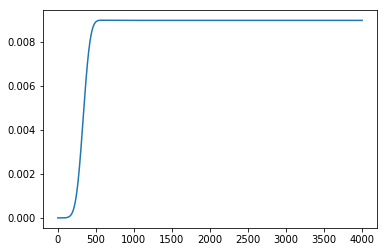

In [133]:
plt.plot(carriers['time'],carriers['dne'])

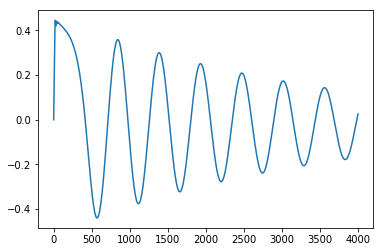

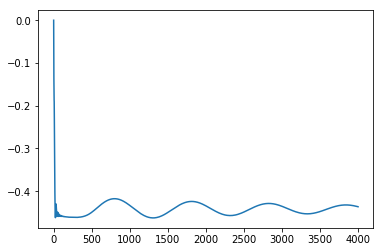

In [134]:
plt.plot(spin['time'],spin['Mc_z'])
plt.show()

plt.plot(spin['time'],spin['Mv_z'])
plt.show()

We can measure the frequency of the oscillations

In [106]:
time = spin['time']
mgn = spin['Mc_z']

In [111]:
from scipy.signal import argrelextrema

In [117]:
t_max = time[argrelextrema(mgn, np.greater)[0]]
t_max

array([  21.,   42.,   62.,  843., 1386., 1930., 2473., 3017., 3560.])

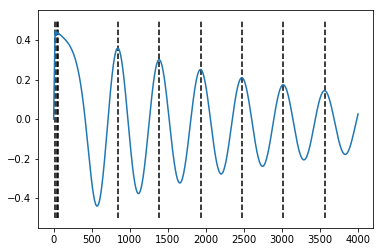

In [118]:
plt.plot(spin['time'],spin['Mc_z'])
for t in t_max:
    plt.vlines(t,-0.5,0.5,linestyles='--')
plt.show()

In [121]:
len(t_max)

9

In [122]:
deltaT = []
for ind in range(len(t_max)-1):
    deltaT.append(t_max[ind+1]-t_max[ind])
deltaT

[21.0, 20.0, 781.0, 543.0, 544.0, 543.0, 544.0, 543.0]

In [127]:
nu = 1./544
e = U.Planck_ev_ps*1e6*nu # 1e6 convert in meV*fs
e

7.602330323529411

__The frequency after the transient exactly matches with the energy difference between c and c' conduction bands!__

In [115]:
print(2*np.pi/(t_max[-1]-t_max[-2]))

0.011571243659630914


In [ ]:
######################################################################à

In [102]:
rold = ['rt_k1-no-sym_old/FixSymm/dephase_0.0001-freq_2.238/o-dephase_0.0001-freq_2.238.spin_magnetization']

In [103]:
dd = P.YamboParser(rold)

In [104]:
sp = dd['spin_magnetization']

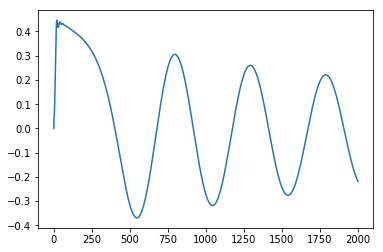

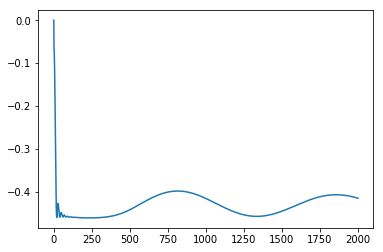

In [105]:
plt.plot(sp['time'],sp['Mc_z'])
plt.show()

plt.plot(sp['time'],sp['Mv_z'])
plt.show()